In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Transformer
It's time.

### Encoder Block
Attention block with a FFN/MLP and add-norm.

In [17]:
from naml.modules import torch
from naml.modules.transformer import EncoderBlock

X = torch.ones((2,100,24))
lens = torch.tensor([3,2])
blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48,8, 0.5)
blk.eval()
Y_enc = blk.forward(X, lens)

### Encoder
Stack of encoder blocks with positional encoding.

In [18]:
from naml.modules.transformer import Encoder

encoder = Encoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 2)
encoder.eval()
encoder.forward(torch.ones((2,100)).long(), lens).shape

torch.Size([2, 100, 24])

### Decoder Block/Decoder
Attention block with a FFN/MLP and add-norm.

To ensure self regressive property, the decoder block has an additional attention block that attends to the encoder output.

In [ ]:
from naml.modules.transformer import DecoderBlock
blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
blk.eval()
X = torch.ones((2,100,24))
Y_dec, K = blk.forward(X, Y_enc, lens, None)
Y_dec.shape

torch.Size([2, 100, 24])

### Training
We'll use `seq2seq` training code again.

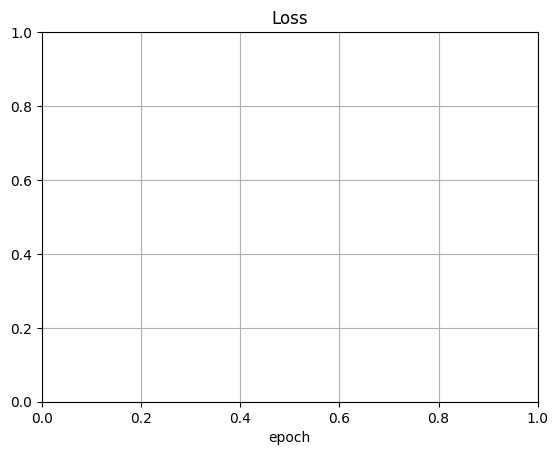

Loss:   0%|          | 0/200 [00:00<?, ?it/s]

TypeError: Encoder.forward() missing 1 required positional argument: 'lens'

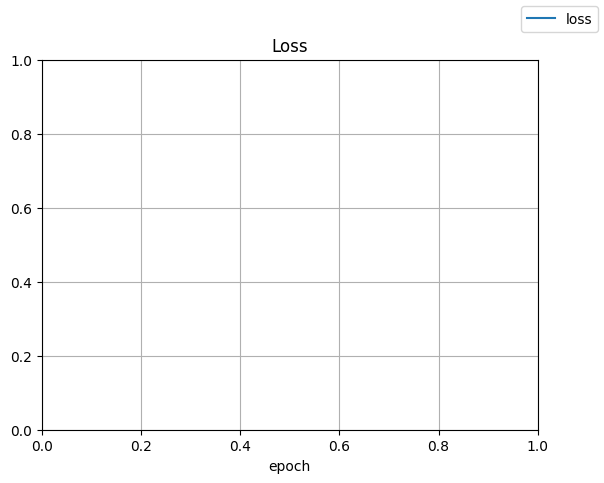

In [26]:
from naml.modules.transformer import Encoder, Decoder
from naml.modules.sequence import EncoderDecoder
n_hidden, num_layers, dropout_p, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, epochs = 0.005, 200
ffn_n_in, ffn_n_hidden, n_heads = 32, 64, 4
n_keys, n_query, n_values = 32, 32, 32
norm_shape = [32]

from naml.text import flatten, Vocabulary
from naml.dataset import Datasets
from naml.dataset.nmt import load_nmt
datasets = Datasets("~/naml-data")
src_words, target_words = load_nmt(datasets, 'cmn', 'eng', max_examples=500)
src_vocab, tgt_vocab = Vocabulary(flatten(src_words)), Vocabulary(flatten(target_words))

encoder = Encoder(len(src_vocab), n_keys, n_query, n_values, n_hidden, norm_shape, ffn_n_in, ffn_n_hidden, n_heads, dropout_p, num_layers)
decoder = Decoder(len(tgt_vocab), n_keys, n_query, n_values, n_hidden, norm_shape, ffn_n_in, ffn_n_hidden, n_heads, dropout_p, num_layers)
net = EncoderDecoder(encoder, decoder)

from naml.modules.sequence import train_seq2seq

train_seq2seq(net, lr, epochs, src_vocab, tgt_vocab, src_words, target_words, batch_size, num_steps)